In [1]:
!unzip /content/drive/MyDrive/majorproject/data-20240317T092757Z-001.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/valid/Mild_Demented/mild_875.jpg  
  inflating: data/valid/Mild_Demented/mild_867.jpg  
  inflating: data/valid/Mild_Demented/mild_385.jpg  
  inflating: data/valid/Mild_Demented/mild_364.jpg  
  inflating: data/valid/Mild_Demented/mild_45.jpg  
  inflating: data/valid/Mild_Demented/mild_835.jpg  
  inflating: data/valid/Mild_Demented/mild_294.jpg  
  inflating: data/valid/Mild_Demented/mild_103.jpg  
  inflating: data/valid/Mild_Demented/mild_23.jpg  
  inflating: data/valid/Mild_Demented/mild_15.jpg  
  inflating: data/valid/Mild_Demented/mild_688.jpg  
  inflating: data/valid/Mild_Demented/mild_524.jpg  
  inflating: data/valid/Mild_Demented/mild_441.jpg  
  inflating: data/valid/Mild_Demented/mild_599.jpg  
  inflating: data/valid/Mild_Demented/mild_504.jpg  
  inflating: data/valid/Mild_Demented/mild_888.jpg  
  inflating: data/valid/Mild_Demented/mild_890.jpg  
  inflating: data/valid/Mild_Demented/mild_676.jpg 

In [11]:
import os
from collections import Counter
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define the paths to your data folders
train_path = '/content/data/train'
valid_path = '/content/data/valid'
test_path = '/content/data/test'

# Define the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation parameters
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, valid, and test data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Get the class labels and number of classes
class_labels = train_generator.class_indices
num_classes = len(class_labels)

# Print class distribution in the train, valid, and test sets
print("Train set class distribution:", Counter(train_generator.classes))
print("Valid set class distribution:", Counter(valid_generator.classes))
print("Test set class distribution:", Counter(test_generator.classes))

Found 3839 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Train set class distribution: Counter({2: 1920, 3: 1344, 0: 537, 1: 38})
Valid set class distribution: Counter({2: 1120, 3: 784, 0: 315, 1: 23})
Test set class distribution: Counter({2: 160, 3: 112, 0: 44, 1: 3})


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend

def dense_block(x, blocks, growth_rate, name):
    """A dense block."""
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def conv_block(x, growth_rate, name):
    """A building block for a dense block."""
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name=name + '_2_conv')(x1)

    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])

    return x

def transition_block(x, reduction, name):
    """A transition block."""
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)

    return x

def DenseNet(blocks, growth_rate=32, reduction=0.5, input_shape=(224, 224, 3), classes=1000):
    """Instantiates the DenseNet architecture."""
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    img_input = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), padding='same', name='conv1/conv')(img_input)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = Activation('relu', name='conv1/relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)

    x = dense_block(x, blocks[0], growth_rate, name='conv2')
    x = transition_block(x, reduction, name='pool2')
    x = dense_block(x, blocks[1], growth_rate, name='conv3')
    x = transition_block(x, reduction, name='pool3')
    x = dense_block(x, blocks[2], growth_rate, name='conv4')
    x = transition_block(x, reduction, name='pool4')
    x = dense_block(x, blocks[3], growth_rate, name='conv5')

    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    num_classes = 4  # Assuming your dataset has 4 classes

# Replace the existing output layer with a new Dense layer for 4 classes
    x = Dense(num_classes, activation='softmax', name='output')(x)

    # Create model.
    model = Model(img_input, x, name='densenet')

    return model

# Example usage:
blocks = [6, 12, 24, 16]  # Dense block configurations
model = DenseNet(blocks)
model.summary()


Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['input_4[0][0]']             
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1/relu (Activation)     (None, 112, 112, 64)         0         ['conv1/bn[0][0]']     

In [15]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os

# Define the paths to your data folders
train_path = '/content/data/train'
valid_path = '/content/data/valid'
test_path = '/content/data/test'

# Define the hyperparameters
batch_size = 16
epochs =30
learning_rate = 0.01
momentum = 0.9

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, valid, and test data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

checkpoint = ModelCheckpoint('Alzhiemer_densenetmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint]
)

# Load the best model
model.save('Alzhiemer_densenetmodel.h5')

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Found 3839 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Epoch 1/30
239/239 [==============================] - ETA: 0s - loss: 3.0074 - accuracy: 0.5470
Epoch 1: val_accuracy improved from -inf to 0.50223, saving model to Alzhiemer_densenetmodel.h5
239/239 [==============================] - 125s 287ms/step - loss: 3.0074 - accuracy: 0.5470 - val_loss: 6.5839 - val_accuracy: 0.5022
Epoch 2/30
239/239 [==============================] - ETA: 0s - loss: 2.8922 - accuracy: 0.6051
Epoch 2: val_accuracy improved from 0.50223 to 0.55446, saving model to Alzhiemer_densenetmodel.h5
239/239 [==============================] - 59s 246ms/step - loss: 2.8922 - accuracy: 0.6051 - val_loss: 3.1694 - val_accuracy: 0.5545
Epoch 3/30
239/239 [==============================] - ETA: 0s - loss: 2.7561 - accuracy: 0.6699
Epoch 3: val_accuracy did not improve from 0.55446
239/239 [==============================] - 56s 234ms/step - loss: 2.7561

<ipython-input-15-ac97762a1c81>:65: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test loss: 1.8129
Test accuracy: 0.9572


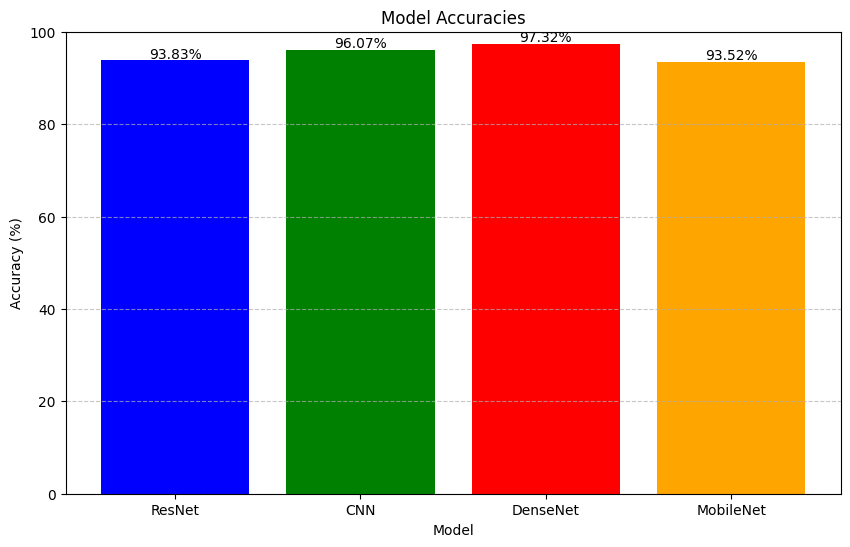

In [1]:
import matplotlib.pyplot as plt

models = ['ResNet', 'CNN', 'DenseNet', 'MobileNet']
accuracies = [93.83, 96.07, 97.32, 93.52]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'])

# Adding text labels above each bar
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.5, f'{accuracies[i]:.2f}%', ha='center')

plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
